# Dependence

In [9]:
import torch
import torch.nn as nn
import torch.autograd as autograd

import numpy as np 

from pyDOE import lhs

import matplotlib.pyplot as plt
import matplotlib.tri as mtri

seed = 42
torch.manual_seed(seed)
np.random.seed(seed)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Parameter

In [ ]:
steps = 1000
layers = np.array([2,32,64,32,2])
lr = 0.001

Nf = 10000  # samples for the PDE loss

# Auxiliary Functions


In [11]:
def Plot(V,tris,U):
    _,ax=plt.subplots()
    ax.tripcolor(V[:,0],V[:,1],tris,U,cmap='viridis')
    ax.set_xlabel('x')
    ax.set_ylabel('y')
    ax.set_title('U')
    plt.show()

# Build initial physical mesh and logical mesh

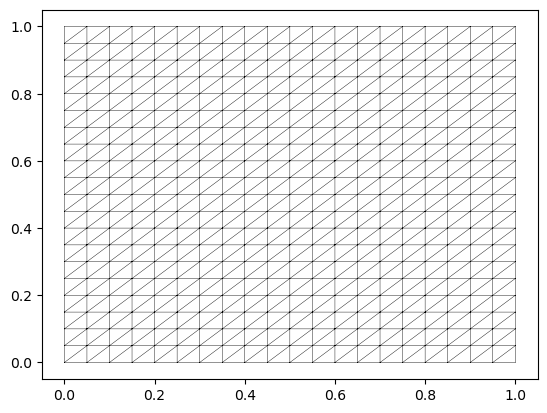

In [12]:
m_rows = 20
m_cols = 20

x = torch.linspace(0, 1, m_cols + 1)
y = torch.linspace(0, 1, m_rows + 1)
x = x.repeat(m_rows + 1)
y = y.repeat_interleave(m_cols + 1)
V_0 = torch.stack([x,y],dim=1) #physical mesh
V_xi_0 = V_0.clone() #logical mesh

tris = []

for i in range(m_cols):
   for j in range(m_rows):
       tris.append([j * (m_cols + 1) + i, j * (m_cols + 1) + i + 1, (j + 1) * (m_cols + 1) + i + 1])
       tris.append([j * (m_cols + 1) + i, (j + 1) * (m_cols + 1) + i + 1, (j + 1) * (m_cols + 1) + i])
        
tris = torch.tensor(tris, dtype=torch.short)

plt.triplot(x,y,tris,'k-',linewidth=0.3)
plt.show()

# Training Data

In [13]:
left_V = V_0[(V_0[:,0]==0.0)]
right_V = V_0[(V_0[:,0]==1.0)]
bottom_V = V_0[(V_0[:,1]==0.0)]
top_V = V_0[(V_0[:,1]==1.0)]

PDE_V = V_0[0] + (V_0[-1]-V_0[0])*lhs(2,Nf)
PDE_V = torch.vstack((left_V,right_V,bottom_V,top_V,PDE_V))

V_0 = V_0.to(device)
V_xi_0 = V_xi_0.to(device)
left_V = left_V.float().to(device)
right_V = right_V.float().to(device)
bottom_V = bottom_V.float().to(device)
top_V = top_V.float().to(device)
PDE_V = PDE_V.float().to(device)

C:\Users\13162\AppData\Local\Temp\ipykernel_24608\4234954010.py:6: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  PDE_V = V_0[0] + (V_0[-1]-V_0[0])*lhs(2,Nf)


# Field functions

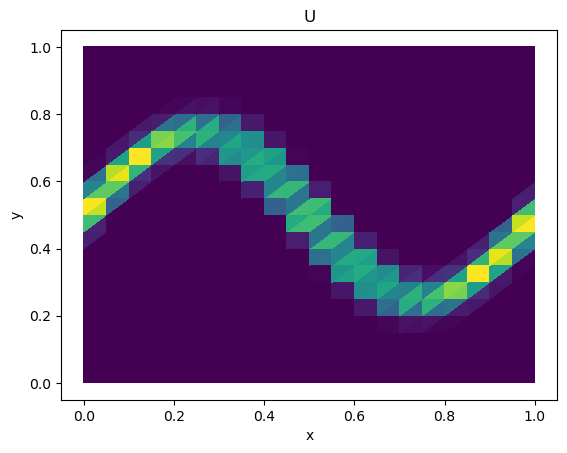

In [14]:
def U(V):
    return torch.tanh(-30*(V[:,1]-0.5-0.25*torch.sin(2*torch.pi*V[:,0])))

def U_x_y(V):
    U_x = (1-U(V)**2)*(15*torch.pi*torch.cos(2*torch.pi*V[:,0]))
    U_y = (1-U(V)**2)*(-30)
    return torch.stack([U_x,U_y],dim=1)

def Metric(V):
    u_x_y = U_x_y(V)
    return torch.sqrt(0.1*torch.linalg.norm(u_x_y,dim=1)**2 + 1)

M = Metric(V_0)
Plot(V_0.detach().cpu(),tris.detach().cpu(),M.detach().cpu())

# Neural Network generate initial physical mesh by solving harmonic maps

$$
g^{ij}\frac{\partial}{\partial \xi^i}w\frac{\partial x^k}{\partial \xi^j} = 0
$$

$$
g^{ij} = \frac{\partial \xi^i}{\partial x^\alpha}\frac{\partial \xi^j}{\partial x^\alpha}
$$


In [15]:
class FCN2(nn.Module):
    def __init__(self,layers):
        super().__init__()
        self.layers = layers 
        self.activation = nn.Tanh()
        self.loss_function = nn.MSELoss(reduction ='mean')
        self.loss_function2 = nn.L1Loss(reduction ='sum')
        self.linears = nn.ModuleList([nn.Linear(layers[i], layers[i+1]) for i in range(len(layers)-1)]) 
        self.iter = 0
        for i in range(len(layers)-1):
            nn.init.xavier_normal_(self.linears[i].weight.data, gain=1.0)
            nn.init.zeros_(self.linears[i].bias.data)   

    def forward(self,x):
        if torch.is_tensor(x) != True:         
            x = torch.from_numpy(x)                
        a = x.float()
        for i in range(len(self.layers)-2):  
            z = self.linears[i](a)              
            a = self.activation(z)
        a = self.linears[-1](a)
        a[:,[0]] = a[:,[0]]*(x[:,[0]])*(1-x[:,[0]]) + x[:,[0]]
        a[:,[1]] = a[:,[1]]*(x[:,[1]])*(1-x[:,[1]]) + x[:,[1]]
        return a    
    
    def loss_BC(self,left_V,right_V,bottom_V,top_V):
        return self.loss_function2(self.forward(left_V),left_V) + \
               self.loss_function2(self.forward(right_V),right_V) + \
               self.loss_function2(self.forward(bottom_V),bottom_V) + \
               self.loss_function2(self.forward(top_V),top_V)
    
    def loss_PDE(self,PDE_V):
        g = PDE_V.clone()
        g.requires_grad = True
        xy = self.forward(g)
        x = xy[:,[0]]
        y = xy[:,[1]]
        M = Metric(xy).unsqueeze(1)
        x_xi_eta = autograd.grad(x,g,torch.ones([g.shape[0],1]).to(device),retain_graph=True,create_graph=True)[0]
        y_xi_eta = autograd.grad(y,g,torch.ones([g.shape[0],1]).to(device),retain_graph=True,create_graph=True)[0]
        M_xi_eta = autograd.grad(M,g,torch.ones([g.shape[0],1]).to(device),create_graph=True)[0]
        x_xi = x_xi_eta[:,[0]]
        x_eta = x_xi_eta[:,[1]]
        y_xi = y_xi_eta[:,[0]]
        y_eta = y_xi_eta[:,[1]]
        x_xixi_xieta = autograd.grad(x_xi,g,torch.ones([g.shape[0],1]).to(device),create_graph=True)[0]
        x_etaxi_etaeta = autograd.grad(x_eta,g,torch.ones([g.shape[0],1]).to(device),create_graph=True)[0]
        y_xixi_xieta = autograd.grad(y_xi,g,torch.ones([g.shape[0],1]).to(device),create_graph=True)[0]
        y_etaxi_etaeta = autograd.grad(y_eta,g,torch.ones([g.shape[0],1]).to(device),create_graph=True)[0]
        xi_x = y_eta
        xi_y = -x_eta
        eta_x = -y_xi
        eta_y = x_xi
        g00 = xi_x*xi_x+xi_y*xi_y
        g01 = xi_x*eta_x+xi_y*eta_y
        g11 = eta_x*eta_x+eta_y*eta_y
        loss1 = g00*(M_xi_eta[:,[0]]*x_xi_eta[:,[0]]+M*x_xixi_xieta[:,[0]]) + \
                g01*(M_xi_eta[:,[0]]*x_xi_eta[:,[1]]+M*x_etaxi_etaeta[:,[0]]) + \
                g01*(M_xi_eta[:,[1]]*x_xi_eta[:,[0]]+M*x_xixi_xieta[:,[1]]) + \
                g11*(M_xi_eta[:,[1]]*x_xi_eta[:,[1]]+M*x_etaxi_etaeta[:,[1]])
        loss2 = g00*(M_xi_eta[:,[0]]*y_xi_eta[:,[0]]+M*y_xixi_xieta[:,[0]]) + \
                g01*(M_xi_eta[:,[0]]*y_xi_eta[:,[1]]+M*y_etaxi_etaeta[:,[0]]) + \
                g01*(M_xi_eta[:,[1]]*y_xi_eta[:,[0]]+M*y_xixi_xieta[:,[1]]) + \
                g11*(M_xi_eta[:,[1]]*y_xi_eta[:,[1]]+M*y_etaxi_etaeta[:,[1]])
        return self.loss_function(loss1,torch.zeros(g.shape[0],1).to(device)) + \
               self.loss_function(loss2,torch.zeros(g.shape[0],1).to(device))

    def loss(self,PDE_V):      
        return self.loss_PDE(PDE_V)
    
    def closure(self):
        optimizer_lbfgs.zero_grad()
        loss = self.loss(PDE_V)
        loss.backward()
        self.iter += 1
        return loss
    
def train_adam(model):
    optimizer = torch.optim.Adam(model.parameters(),lr=lr,amsgrad=False)
    optimizer.zero_grad()
    loss = model.loss(PDE_V)
    loss.backward()
    optimizer.step()
    return loss.detach().cpu().numpy()
    
def train_lbfgs(model):
    optimizer_lbfgs = torch.optim.LBFGS(model.parameters(), lr=0.1, max_iter=1, history_size=50)
    loss = optimizer_lbfgs.step(model.closure)
    return loss.detach().cpu().numpy()
        

# Generate initial physical mesh

In [16]:
x_new = FCN2(layers).to(device)

best_loss = 1e10
adam_early_stop = 10000
early_stop_count = 0
early_stop_step = 0
optimizer_adam = torch.optim.Adam(x_new.parameters(),lr=lr,amsgrad=False)
for i in range(steps):
    loss = x_new.loss(PDE_V)
    optimizer_adam.zero_grad()
    loss.backward()
    # torch.nn.utils.clip_grad_norm_(xi_new.parameters(), 1.0)
    optimizer_adam.step()
    if(loss.detach().cpu().numpy() < best_loss):
        best_loss = loss.detach().cpu().numpy()
        print('adam', i, best_loss)
        early_stop_count = 0
    else:
        early_stop_count += 1
    if early_stop_count > adam_early_stop:
        early_stop_step = i
        break
    
if early_stop_step != 0:
    optimizer_lbfgs = torch.optim.LBFGS(x_new.parameters(), lr=1.0, max_iter=10, history_size=50)
    for i in range(early_stop_step,steps):
        loss = optimizer_lbfgs.step(x_new.closure)
        print('lbfgs', i,loss.detach().cpu().numpy())
    
V_new = x_new(V_xi_0)
plt.triplot(V_new.detach().cpu()[:,0],V_new.detach().cpu()[:,1],tris.detach().cpu(),'k-',linewidth=0.3)

adam 0 16992.568


KeyboardInterrupt: 

# Update physical mesh

In [ ]:
# V_new.require_grads = True
# xi_x_y = autograd.grad(V_new[:,0].unsqueeze(1),V,torch.ones([V.shape[0],1]).to(device),retain_graph=True,create_graph=True)[0]
# eta_x_y = autograd.grad(V_new[:,1].unsqueeze(1),V,torch.ones([V.shape[0],1]).to(device),retain_graph=True,create_graph=True)[0]
# xi_x,xi_y,eta_x,eta_y = xi_x_y[:,[0]],xi_x_y[:,[1]],eta_x_y[:,[0]],eta_x_y[:,[1]]
# delta_V_xi = V_xi_0 - V_new
# delta_V_xi_x = delta_V_xi[:,0].unsqueeze(1)
# delta_V_xi_y = delta_V_xi[:,1].unsqueeze(1)
# delta_V_x = (1/(xi_x*eta_y-xi_y*eta_x)*(eta_y*delta_V_xi_x-xi_y*delta_V_xi_y)).squeeze()
# delta_V_y = (1/(xi_x*eta_y-xi_y*eta_x)*(-eta_x*delta_V_xi_x+xi_x*delta_V_xi_y)).squeeze()
# delta_V = torch.stack([delta_V_x,delta_V_y],dim=1)
# delta_V = delta_V / torch.linalg.norm(delta_V,dim=1).unsqueeze(1)*0.01
# delta_V[V[:,0]==0.0] = 0.0
# delta_V[V[:,0]==1.0] = 0.0
# delta_V[V[:,1]==0.0] = 0.0
# delta_V[V[:,1]==1.0] = 0.0

# new_V = (V + delta_V).detach().cpu()

# plt.triplot(new_V[:,0],new_V[:,1],tris.detach().cpu(),'k-',linewidth=0.3)
# plt.show()